<div style="text-align: right">  
Notebook created by Hans De Moel and Marthe Wens <br>
Within the UNDRR - CIMA Risk Profile Project
</div>
Drought Risk Assessment
============

## Drought Hazard 
The **first part**  of this script will calculate different standardized drought indices for a time series of hydrological data (raster maps) with different accumulation times (for example for the cumulative sum over 3 or 6 months of Precipitation amounts).
To identify droughts, a custom drought duration and intensity threshold can be chosen in the **second part** of the script; After defining the characteristics of 'a drought event', one can calculate the probabilities and return periods of droughts 
for different time periods. This will be done in the **third part** of the script.
 <br>
## Drought Exposure 
To evaluate drought exposure, the created drought hazard files can be combined with exposure maps, as will be done in the **fourth part** of the script. Hence, once can calculate the annually average and probable maximum people, livestock, gdp, ... potentially affected by drought. This is done with a simple overlay and results are summed per admin1 regions (i.e. provinces).
 <br>
## Drought Vulnerability 
We can try to estimate drought vulnerability by linking drought impacts (found in a PDNA) to the hazard indicators. Knowing how much percent of the exposed items (eg people, livestock) were severly affected (malnutrition, mortality), it is possible to  find a relation between severity of the drought hazard and experienced impact. This will be done in the **fifth part** of the script. As such, we can finetune the drought thresholds and use this relation to estimate drought impact in future periods (assuming no change in vulnerability).

# 0. Setup
Set the working directory to your the folder path on your computer, and choose the country you want to evaluate.

In [1]:
import os
os.chdir('G:/PhD/UNDroughtProfiles')
import xarray as xr
import numpy as np
import scipy.stats as stats
import matplotlib
import matplotlib.pyplot as plt
from osgeo import gdal, osr, ogr
import xlsxwriter
import pandas as pd
import warnings
#import FFTrees
warnings.filterwarnings("ignore")

In [2]:
# Choose country of analysis
country = 'zambia' 

In [3]:
# Set up data sources
workingfolder = os.getcwd()
inputfolder   = os.path.join(workingfolder,'Input')   #location of tif files
datafolder    = os.path.join(workingfolder,'Data')    #location of nc files
outputfolder  = os.path.join(workingfolder,'Output')  #location to save output

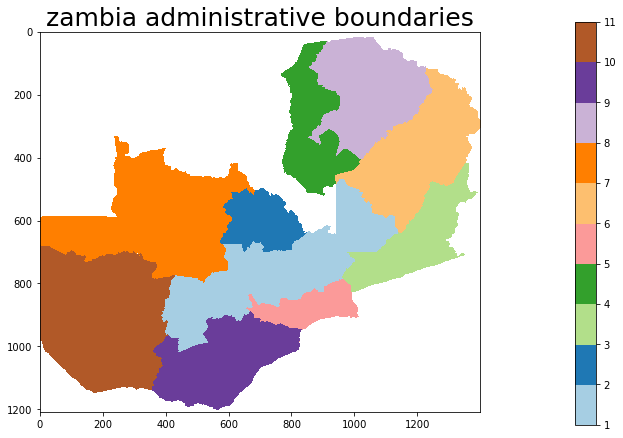

In [4]:
#  Administrative levels to summarize exposure information              
src = gdal.Open(os.path.join(inputfolder,country+'_lvl1_kron.tif'))
Admin1 = src.GetRasterBand(1).ReadAsArray()                              
admin = Admin1 - np.min(Admin1[Admin1>0]) +1 # number regions from 1 to x

cmap = matplotlib.cm.get_cmap('Paired')
bounds = np.linspace(1, len(np.unique(admin)), len(np.unique(admin)+1))
norm = matplotlib.colors.BoundaryNorm(bounds, cmap.N)
cmap.set_under(color='white')

fig = plt.figure(figsize=(10,7)) 
plt.title(country+' administrative boundaries',size=25)
im = plt.imshow(admin, cmap = cmap, norm=norm )  
ax2 = fig.add_axes([0.95, 0.1, 0.03, 0.8])
cb = matplotlib.colorbar.ColorbarBase(ax2, cmap=cmap, norm=norm,spacing='proportional', ticks=bounds, boundaries=bounds, format='%1i')
plt.show()

# 0. Read input data
Here all input files (if they exist in your data folder) are automatically evaluated. All hydrological input data will be visualised. Please check if the file names are similar to the input files in your data folder, indicate the start and end period of the data.  

In [5]:
# Name input file ( * signifies that there are multiple; NAN if none)

print('Precipitation data:')
Prfiles  = os.path.join(datafolder,country+'.RainDaily.*.moncumulate*.nc')
Pr       = xr.open_mfdataset(Prfiles, mask_and_scale=True, concat_dim='time', decode_times=True)
print(Pr)

print('\nActual Evapotranspiration data:')
EvTfiles = os.path.join(datafolder,country+'.ETRealDaily.*.moncumulate*.nc')
Evt      = xr.open_mfdataset(EvTfiles, mask_and_scale=True, concat_dim='time', decode_times=True)
print(Evt)

print('\nPotential Evaporation data:')
PETfiles = os.path.join(datafolder,country+'.ETPotDaily.*.moncumulate*.nc')
PET      = xr.open_mfdataset(PETfiles, mask_and_scale=True, concat_dim='time', decode_times=True)
print(PET)

print('\nStreamflow data:')
Qfiles   = os.path.join(datafolder,country+'.QDaily.*.moncumulate*.nc')
Q        = xr.open_mfdataset(Qfiles, mask_and_scale=True, concat_dim='time', decode_times=True)
print(Q)

print('\nSoil Moisture data:')
SMfiles  = os.path.join(datafolder,country+'.SoilMoistureDaily.*.moncumulate*.nc')
SM       = xr.open_mfdataset(SMfiles, mask_and_scale=True, concat_dim='time', decode_times=True)
print(SM)

Precipitation data:
<xarray.Dataset>
Dimensions:    (bnds: 2, lat: 121, lat_2: 121, lon: 140, lon_2: 140, time: 1800)
Coordinates:
  * lon        (lon) float64 22.04 22.13 22.21 22.29 22.38 22.46 22.54 22.63 ...
  * lat        (lat) float64 -8.125 -8.208 -8.292 -8.375 -8.458 -8.542 ...
  * lon_2      (lon_2) float64 22.06 22.14 22.23 22.31 22.39 22.48 22.56 ...
  * lat_2      (lat_2) float64 -8.145 -8.228 -8.311 -8.394 -8.478 -8.561 ...
  * time       (time) datetime64[ns] 1951-01-16 1951-02-14T12:00:00 ...
Dimensions without coordinates: bnds
Data variables:
    time_bnds  (time, bnds) float64 dask.array<shape=(1800, 2), chunksize=(348, 2)>
    Rain       (time, lon, lat) float32 dask.array<shape=(1800, 140, 121), chunksize=(348, 140, 121)>
    DTM        (time, lon_2, lat_2) float32 dask.array<shape=(1800, 140, 121), chunksize=(348, 140, 121)>
    ACPx       (time, lon_2, lat_2) float32 dask.array<shape=(1800, 140, 121), chunksize=(348, 140, 121)>
Attributes:
    CDI:          Climat

In [6]:
# Indicate the time for which data is available
start = 1951
end   = 2005
years = end - start 

In [7]:
def plot_mean(indata,title):

    info = np.nanmean(indata, axis=0)*12
    minval = np.nanpercentile(info[info!=0],5)
    maxval = np.nanpercentile(info[info!=0],95)
    
    fig = plt.figure(figsize=(10,7))
    plt.title(title+' ', size=20)   
    im = plt.imshow(info, cmap = matplotlib.cm.get_cmap('YlGnBu'), vmin=minval, vmax=maxval)
    im.axes.get_xaxis().set_visible(False)
    im.axes.get_yaxis().set_visible(False)
    cbar = fig.colorbar(im)
    cbar.ax.tick_params(labelsize=20) 
    fig.savefig(os.path.join(outputfolder,country+title+'.png'))  
    plt.show()

    return

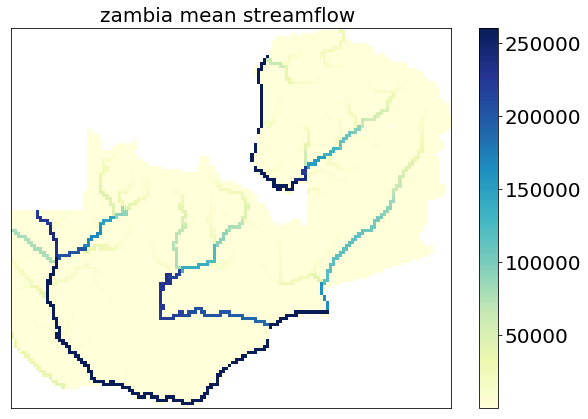

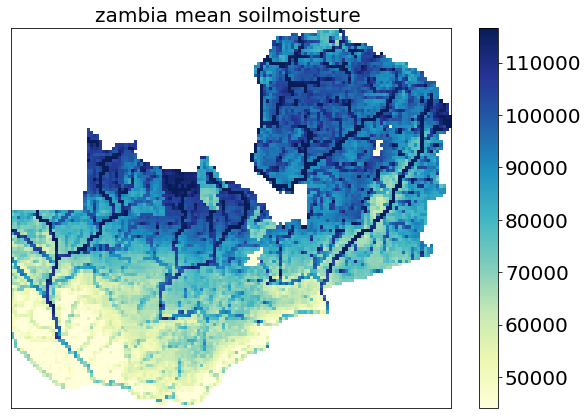

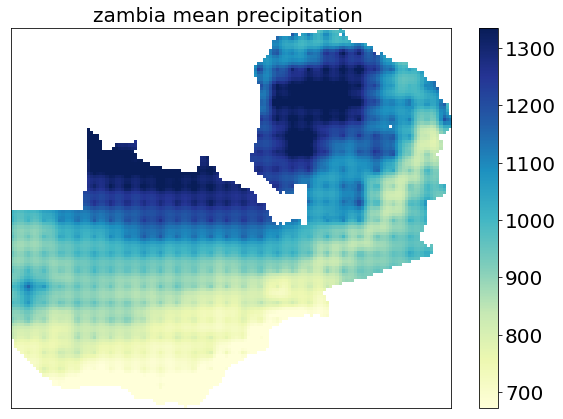

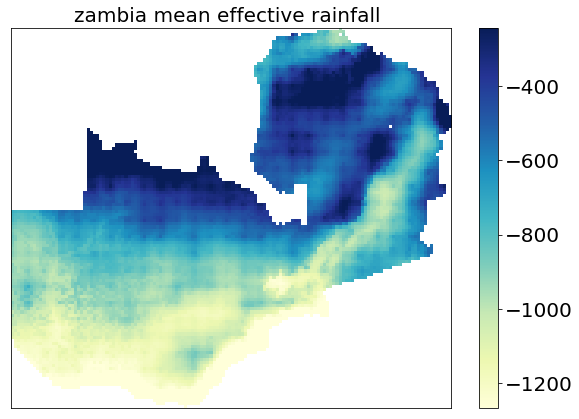

In [8]:
# Create input dictionary and show maps of input
parameters = {}                                                          

parameters['streamflow']    = np.transpose(Q.Qmap.values, (0, 2, 1))
plot_mean(parameters['streamflow'], country+' mean streamflow')

parameters['soilmoisture']  = np.transpose(SM.WatVol_RZ.values, (0, 2, 1))
plot_mean(parameters['soilmoisture'], country+' mean soilmoisture')

parameters['precipitation'] = np.transpose(Pr.Rain.values, (0, 2, 1))
plot_mean(parameters['precipitation'], country+' mean precipitation')

parameters['pr - potevt']   = np.transpose(Pr.Rain.values, (0, 2, 1)) - np.transpose(PET.DailyETP_PMFAO.values, (0, 2, 1))
plot_mean(parameters['pr - potevt'], country+' mean effective rainfall')

# 1. Calculate drought indices
Here we can calculate the standardized indices following the method explained in the powerpoint. **We did this already for you since it takes a lot of time, so you do NOT need to run these.**

In [ ]:
# Choose standardized indices used in analysis

indices = ['SPEI', 'SPI','SSMI','SSFI']
indicesfull = ['Standardized Precipitation Evapotranspiration Index','Standardized Precipitation Index','Standardized Soil Moisture Index','Standardized Streamflow Index']  


In [ ]:
# Choose hydrological data accumulation time 
    
accumulationtimes = [1,3,6,12]

In [ ]:
# Dictionary to store indices output
standardizedindices = {}
standardizedindices['SPEI'] = 'pr - potevt'
standardizedindices['SPI']  = 'precipitation'
standardizedindices['SSFI'] = 'streamflow'
standardizedindices['SSMI'] = 'soilmoisture'

In [ ]:
# Prepare netCDF output
variables = {}       
variables['time'] = Pr['time']
variables['lon'] = Pr['lat']     
variables['lat'] = Pr['lon'] # Transposed
variables['attrs'] = Pr.Rain.attrs
variables['dims'] = Pr.Rain.dims
variables['coords'] = Pr.Rain.coords

In [ ]:
# function to accumulate hydrological data
   # with a the input data and b the accumulation time
   # -> the accumulated value coincidences with the position of the last value 
   #     used in the accumulation process.

def moving_sum(a, b) :
    
    cummuldata = np.cumsum(a, dtype=float)                 
    cummuldata[b:] = cummuldata[b:] - cummuldata[:-b]         
    cummuldata[:b - 1] = np.nan                                           
    
    return cummuldata

In [ ]:
# function to calculate standardized indices per month
    # with a the full accumulated data series over which the index is calculated
    # and b the standardized index that is analysed

def calculate_Index(a, b):
      
    indexvalues = a * np.nan                        
    for m in range(12):  
     
        # Extract monthly values
        monthlyvalues = np.zeros(int(len(a)/12)+1) * np.nan
        for yr in range(int(len(a)/12)): 
            monthlyvalues[yr] = accumulateddata[(12*yr)+m]                                 
                                
        # Retrieve index per month
        Zval = calculate_Zvalue(monthlyvalues,b)
                            
        # Reconstruct time series
        for yr in range(int(len(a)/12)):
            indexvalues[(12*yr)+m] = Zval[yr]
            
    return indexvalues     

In [ ]:
# function to calculate Z values for a time series of one selected month
    # with a the data series over which the index is calculated
    # and b the standardized index that is analysed 
                            
def calculate_Zvalue(a, b):
        
    # extract reference time series
    referenceseries = a[:50]    
    
    # find fitting distribution for reference sereis
    best_dist, best_p, params = get_best_distribution(referenceseries, b)  
    
    # fit full time series over best distribution
    z = np.zeros(len(a))
    dist = getattr(stats, str(best_dist))                                   
    rv = dist(*params)         
        
    # Create suitable cummulative distribution function
    # Solve issue with zero values in Gamma distribution (cfr.Stagge et al. 2015)
    if dist == 'gamma':                                                     
        nyears_zero = len(a) - np.count_nonzero(a)
        p_zero = nyears_zero / len(a)
        p_zero_mean = (nyears_zero + 1) / (2 * (len(a) + 1))           

        ppd = (a * 0 ) + p_zero_mean
        ppd[np.nonzero(a)] = p_zero+((1-p_zero)*rv.cdf(a[np.nonzero(a)]))
       
    else:
        ppd = rv.cdf(a)
    
    # Standardize the fitted cummulative distribtuion distribution 
    z = stats.norm.ppf(ppd)                                   
    
    # limit extreme, unlikely values 
    z[z>3] = 3
    z[z<-3] = -3 
            
    return z

In [ ]:
# function to find the best fitting statistical distribution
    # with a the reference time series to test the distributions 
    # and b the standardized index that is analysed
    # (possible distributions differ per hydrological data source)

def get_best_distribution(a, b):
    
    if b == 'SPEI':                     # Suggestions by Stagge et al. (2015) 
        dist_names = ['norm','genextreme', 'genlogistic', 'pearson3']                  
    elif b == 'SSMI':                   # Suggestions in Ryu et al. (2005)
        dist_names = ['norm','beta',  'pearson3','fisk']                               
    elif b == 'SPI' :                   # Suggestions by Stagge et al. (2015) 
        dist_names = ['norm','gamma', 'weibull_min', 'logistic']
    elif b == 'SSFI':                   # Suggestions by Vincent_Serrano et al. (2012)
        dist_names = ['weibull_min','lognorm', 'pearson3', 'genextreme'] 
    else:
        print('problem finding distribution')

    # find fit for each optional distribution
    dist_results = []
    params = {}
    for dist_name in dist_names:                                                # Find distribution parameters        
        dist = getattr(stats, dist_name)
        param = dist.fit(a)
        params[dist_name] = param
        
        # Assess goodness-of-fit using Kolmogorov–Smirnov test
        D, p = stats.kstest(a, dist_name, args=param)                      # Applying the Kolmogorov-Smirnov test
        dist_results.append((dist_name, p))
  
    # find best fitting statistical distribution
    best_dist, best_p = (max(dist_results, key=lambda item: item[1]))           # Select the best fitted distribution

    return best_dist, best_p, params[best_dist]

In [ ]:
# function to save output to netCDF format
    # with a input data source
    # and b output name
         
def save_to_nc(a, b, varis):
  
    da = xr.DataArray(a,name=b,coords=varis['coords'],dims=varis['dims'],attrs=varis['attrs'])
    ds = da.to_dataset(name=b)
    nc_out = os.path.join(os.path.join(outputfolder,b+'.nc4'))
    ncx = ds.to_netcdf(nc_out,engine='scipy')

    return ncx

In [ ]:
## MAIN SCRIPT ##
# Loops over all indices and all accumulation times

for i, index in enumerate(indices):   
         
    param = standardizedindices[index]
    print('analyse '+param) 
    
    data = parameters[param]
    plot_maps(data, country+' '+param, matplotlib.cm.get_cmap('YlGnBu'))
    
    for acc in range(len(accumulationtimes)): 
        accumulation = accumulationtimes[acc]
        
        print('calculate '+index+str(accumulation))
            
        # Prepare empty output files
        StandardizedIndex  = np.zeros((data.shape[0],data.shape[1],data.shape[2])) * np.nan 
               
        # Loop over all pixels
        for lo in range(len(variables['lon'])):
            
            print(int(100 * lo / len(variables['lon'])),"%") 
            
            for la in range(len(variables['lat'])):
                    
                # Select data per pixel and month  
                pixel = data[:,lo,la] 
                pixel[pixel == -999] = np.nan # wrong data
                    
                # Make sure no false data is there (Nan, zeroes)
                if np.isnan(pixel).sum() < 1 :#and np.max(pixel) > 10:                             
                        
                    # Calculate accumulated dataset  ! accumulation leaves an incomplete first year;
                    accumulateddata = moving_sum(pixel,accumulation)

                    # Calculate standardized index
                    StandardizedIndex[12:,lo,la] = calculate_Index(accumulateddata[12:], index)
                                  
        # save and plot Standardized Index
        nameout =  country+' '+index+str(accumulation)          
        nc = save_to_nc(np.transpose(StandardizedIndex, (0, 2, 1)), nameout, variables)   
        

In [ ]:
# function to plot three diverse maps to present the data
    # with a the data to present
    # and b the title
    
def plot_maps(a, b, c):
                  
    #spatial average per month

    yearlymean = np.nanmean(np.nanmean(StandardizedIndex, axis=(1)), axis=(1)).tolist()
    minval=yearlymean.index(np.nanmin(yearlymean))
    medval=yearlymean.index(np.sort(yearlymean)[int(len(yearlymean)/2)])
    maxval=yearlymean.index(np.nanmax(yearlymean))
    
    # create figure
    fig = plt.figure(figsize=(30,10))  
    
    ax1 = plt.subplot(1,3,1)    
    im = ax1.imshow(StandardizedIndex[maxval,:,:], cmap = c, vmin = -3, vmax = 3) 
    ax1.set_title('WET month', size=28)
    im.axes.get_xaxis().set_visible(False)
    im.axes.get_yaxis().set_visible(False)

    ax2 = plt.subplot(1,3,2)    
    im = ax2.imshow(StandardizedIndex[medval,:,:], cmap = c, vmin = -3, vmax = 3)
    ax2.set_title('NORMAL month', size=28)        
    im.axes.get_xaxis().set_visible(False)
    im.axes.get_yaxis().set_visible(False)
                 
    ax3 = plt.subplot(1,3,3)
    im = ax3.imshow(StandardizedIndex[minval,:,:], cmap =  c, vmin = -3, vmax = 3) 
    ax3.set_title('DRY month', size=28)
    im.axes.get_xaxis().set_visible(False)
    im.axes.get_yaxis().set_visible(False)

    fig.subplots_adjust(right=0.8)
    cbar_ax = fig.add_axes([0.85, 0.15, 0.05, 0.7])
    cbar = fig.colorbar(im, cax=cbar_ax)
    cbar.ax.tick_params(labelsize=20) 
    
    plt.suptitle(b,size=40)
    plt.show()
    fig.savefig(os.path.join(outputfolder,b+'_3mapsN.png'))
    
    return 

In [ ]:
# Visualise indices maps

ix = 'SPI' # choose index to visualise
ac = '3' # choose accumulation time to visualise
infile  = xr.open_dataset(os.path.join(outputfolder,country+' '+ix+str(ac)+'.nc4'), mask_and_scale=True, decode_times=True)
StandardizedIndex = np.transpose(infile[country+' '+ix+str(ac)].values, (0, 2, 1))
        
plot_maps(StandardizedIndex, country+' '+ix+ac, matplotlib.cm.get_cmap('RdYlBu'))

# 3. Choose Drought Threshold 
Here are different methods to define your droughts; ways to verify the minimum intensity and minimum duration of a dry spell to be characterised as a drought. An easy approach is the climate-dependent threshold, which is automatically generated based on the aridity index. We can also manualy (in excel) verify the thresholds that are exceeded when impacts are experienced. Lastly, there is an automatic, machine learning technique to find the thresholds (not in the script).

In [29]:
# Choose standardized indices used in threshold analysis

ixs = ['SPI','SPEI','SSMI'] # choose index to visualise
acs = ['3','6'] # choose accumulation time to visualise

Indices_dict = {}
for ix in ixs:
    for ac in acs :
        infile  = xr.open_dataset(os.path.join(outputfolder,'zambesi_'+ix+str(ac)+'.nc4'), mask_and_scale=True, decode_times=True)
        Indices_dict['{}_{}'.format(ix,ac)] = infile['zambesi_'+ix+str(ac)].values
 

In [30]:
# Function to export all standardized values per admin regio to excel to evaluate threshold choice

# Import file with admin1 regions
src = gdal.Open(os.path.join(datafolder, "Zambesi/ZM_lvl1_final.tif"))
mask = src.GetRasterBand(1).ReadAsArray()
mask = np.flipud(mask)

# Define some general parts for the excel file
Admin_names = ['Central', 'Copperbelt', 'Eastern', 'Luapula', 'Lusaka', 'Muchinga', 'North-Western', 'Northern', 'Southern', 'Western']
Header_names = ['Year', 'Month', 'Drought'] + list(Indices_dict.keys())
Years = np.kron(list(range(1979, 2019)),np.ones((1,12))).flatten()
Months = list(range(1,13))*40
workbook = xlsxwriter.Workbook(os.path.join(outputfolder,'Zambezi_Drought_Indices.xlsx'), {'nan_inf_to_errors': True})

#Loop over admin1 regions (to different sheets)
for nr, a in enumerate(Admin_names):
    admin_mask = mask == nr+1
    row=0
    col=0
    #Evaluate mean values per admin1 and create table for excel
    for_excel = pd.DataFrame()        
    for i, ind in enumerate(Indices_dict):
        forsize = Indices_dict[ind].shape[0]
        forpandas = []
        for month in range(forsize):
            data = Indices_dict[ind][month,:,:]
            forpandas.append(np.nanmean(data[admin_mask]))
        for_excel[ind] = forpandas          
    #Write to Excel
    worksheet = workbook.add_worksheet(a)
    for i, name in enumerate(Header_names):
        worksheet.write(row,col+i,name)
    for i, name in enumerate(Years):
        worksheet.write(row+1+i,col,name)
    for i, name in enumerate(Months):
        worksheet.write(row+1+i,col+1,name)
    for col, data in enumerate(for_excel.values.T):
        worksheet.write_column(row+1, col+3, data)
workbook.close()

In [31]:
# Choose drought threshold 
intensitythreshold = -1 # one number, "climate-dependent", "regio-specific"  
durationthreshold = 3

In [32]:
# if intensitythreshold == 'climate-dependent':

Pr  = np.transpose(xr.open_mfdataset(os.path.join(data,'Zambesi/ETcumPot_AF*.nc'), mask_and_scale=True, concat_dim='time', decode_times=True).Rain.values, (0, 2, 1))
PET = np.transpose(xr.open_mfdataset(os.path.join(data,'Zambesi/Rain_AF*.nc'), mask_and_scale=True, concat_dim='time', decode_times=True).DailyETP_PMFAO.values, (0, 2, 1))
    
AridityIndex  = ( np.mean(Pr, axis=0) * 365 ) / ( np.mean(PET, axis=0) * 365 )
    
Droughtthresholds = Pr * np.nan
Droughtthresholds =  -0.9 * AridityIndex - 0.8
Droughtthresholds[Droughtthresholds>-0.5] = -0.5
Droughtthresholds[Droughtthresholds<-1.8] = -1.8  

TypeError: expected str, bytes or os.PathLike object, not numpy.ndarray

In [33]:
# if intensitythreshold == 'regio-specific':
Droughtthresholds = mask
    
Droughtthresholds[mask==1] = -1.0  # threshold value for Central
Droughtthresholds[mask==2] = -1.1  # threshold value for Copperbelt
Droughtthresholds[mask==3] = -1.5  # threshold value for Eastern
Droughtthresholds[mask==4] = -1.3  # threshold value for Luapula
Droughtthresholds[mask==5] = -1.2  # threshold value for Lusaka
Droughtthresholds[mask==6] = -1.4  # threshold value for Muchinga
Droughtthresholds[mask==7] = -1.6  # threshold value for North-Western
Droughtthresholds[mask==8] = -1.8  # threshold value for Northern
Droughtthresholds[mask==9] = -2.0  # threshold value for Southern
Droughtthresholds[mask==10] = -1.7 # threshold value for Western

In [35]:
# if fixed value for full country
Droughtthresholds = mask    
Droughtthresholds[mask>0] =  -1 # threshold value for full country

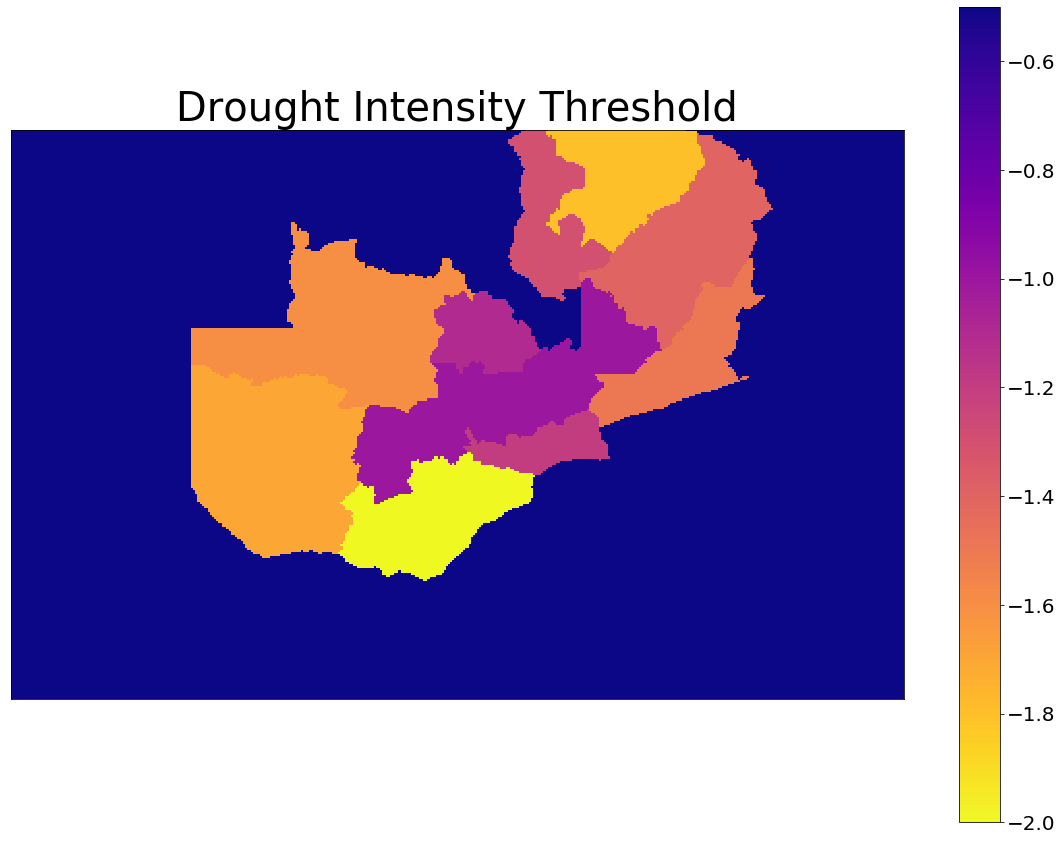

In [36]:
# Plot and save drought threshold map
fig = plt.figure(figsize=(20,15))
plt.title('Drought Intensity Threshold', size=40)   
im = plt.imshow(np.flipud(Droughtthresholds), cmap = matplotlib.cm.get_cmap('plasma_r'), clim=(-2,-0.5))
im.axes.get_xaxis().set_visible(False)
im.axes.get_yaxis().set_visible(False)
cbar = fig.colorbar(im)
cbar.ax.tick_params(labelsize=20) 
fig.savefig(os.path.join(outputfolder,'Thresholdmap.png'))  
plt.show()

# 4. Assess Drought Hazard
After choosing the intensity and duration thresholds, the probability maps can be created for the chosen indices

In [65]:
# Choose standardized indices used in hazard analysis

indices = ['SPEI']
indicesfull = ['Standardized Precipitation Evapotranspiration Index','Standardized Precipitation Index','Standardized Soil Moisture Index','Standardized Streamflow Index']  

accumulationtimes = ['3']

periods     = ['past climate']
periodstart = [1970] 
periodsend  = [2015]

In [66]:
# function to identify drought events
    # with a the standardized values and b the drougth threshold
    # ! nothing is done with severity and drought months - possible future extension

def calculate_Probability(a, b):
    
    a = a[~np.isnan(a)]

    # If higher than intensity threshold: call it drought month
    duration = a * 0
    deficit = a * 0
    for t in range(1,len(a)):
        if a[t] <= b:
            duration[t] = duration[t-1] + 1
            deficit[t] = deficit[t-1] + ( b - a[t] )
        else:
            duration[t] = 0
            deficit[t] = 0
                  
    # If higher than time threshold: call it drought event
    droughtevents = np.sum(duration == durationthreshold) 
    
    # Option to work with deficit
    #droughtevents = np.sum(deficit == minimummonths) 

    # Calculate probability of occurence of drought event per year
    zt = (100 * ( droughtevents / (len(a)/12) ) )+ 1           
           
    # Calculate return period of drought events (in months)
    #zp = ((len(a)/12) + 1 ) / droughtevents
    
    return droughtevents

In [72]:
# function to save hazard output to jpg format
    # with a input data source
    # and b output name
    
def hazard_plot(a,b,c,d,e):
    
    # create color map
    cmap = matplotlib.cm.get_cmap("OrRd")
    color_list = cmap(np.linspace(0, 1, 26))[2:,:-1]
    cmap_name = cmap.name + str(11)
    cmap = cmap.from_list(cmap_name, color_list, 25)
    cmap.set_bad(color='white')
    cmap.set_under(color='grey')
    
    data = np.ma.masked_where(np.isnan(a), a)
    
    fig = plt.figure(figsize=(10,8)) 
    plt.title(b, size=32) 
    im = plt.imshow(data, cmap = cmap, vmin= 0, vmax=30)
    
    cbar = fig.colorbar(im, ticks = [0,5,10,15,20,25,30], orientation="vertical")
    cbar.set_label("drought probability (%)", size=14)
    cbar.ax.tick_params(labelsize=20) 
    
    im.axes.get_xaxis().set_visible(False)
    im.axes.get_yaxis().set_visible(False)
        
    text ="Annual average chance of having three or more drought months\nbased on the "+c+"\n with accumulated data of "+d+" months"
    fig.text(0.10,0.12, text, fontsize=18, ha='left', va='top', wrap=True)
            
    fig.savefig(os.path.join(outputfolder,e+'.png'))
    plt.plot()
    
    return

In [73]:
# function to save output to TIF format
    # with a input data source
    # and b output name
def save_to_tif(a, b, varis): 

    cols        = a.shape[1]
    rows        = a.shape[0]
    originX     = np.min(varis['lat']) #top left point
    originY     = np.max(varis['lon']) #top left point
    pixelWidth  = (np.max(varis['lat'])-np.min(varis['lat']))/(varis['lat'].shape[0]-1)
    pixelHeight = - (np.max(varis['lon'])-np.min(varis['lon']))/(varis['lon'].shape[0]-1)

    driver = gdal.GetDriverByName('GTiff')
    outRaster = driver.Create(b, cols, rows, 1, gdal.GDT_Byte)
    outRaster.SetGeoTransform((originX, pixelWidth, 0, originY, 0, pixelHeight))
    outband = outRaster.GetRasterBand(1)
    outband.WriteArray(a)
    outRasterSRS = osr.SpatialReference()
    outRasterSRS.ImportFromEPSG(4326)
    outRaster.SetProjection(outRasterSRS.ExportToWkt())
    outband.FlushCache()
    
    return

calculate hazard SPEI3


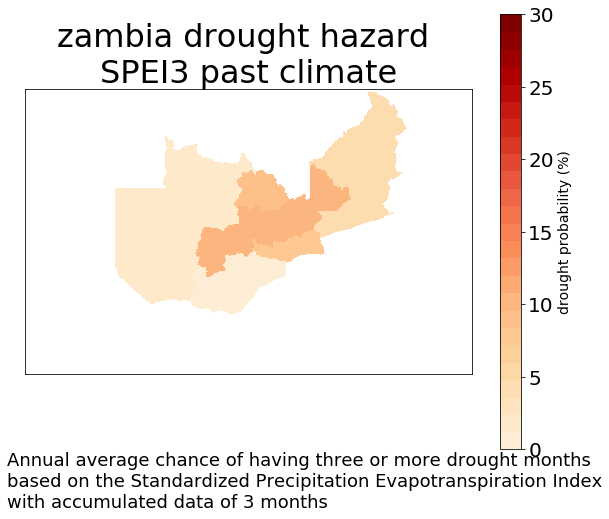

In [74]:
# MAIN SCRIPT #

for i, index in enumerate(indices):   
                
    for acc in range(len(accumulationtimes)): 
        accumulation = accumulationtimes[acc]
        print('calculate hazard '+index+str(accumulation))
                   
        # Open Indices file:
        infile  = xr.open_dataset(os.path.join(outputfolder,'zambesi_'+index+str(accumulation)+'.nc4'), mask_and_scale=True, decode_times=True)
        StandardizedIndex = infile['zambesi_'+index+str(accumulation)].values

        # Prepare empty output files
        DroughtHazardMap   = np.zeros((len(periods),StandardizedIndex.shape[1],StandardizedIndex.shape[2])) * np.nan
        
        variables = {}       
        variables['time'] = infile['time']
        variables['lon'] = infile['lon']  

        variables['lat'] = infile['lat'] 

        # Loop over all pixels
        for lo in range(len(infile['lon'])):
         
            for la in range(len(infile['lat'])):
                    
                # Select data per pixel and month  
                pixel = StandardizedIndex[:,la,lo]                            
                
                if np.isnan(pixel).sum() < 100 :
               
                    for per, period in enumerate(periods):                         
                        
                        # Calculate probabilities FOR FULL period ! Adjust if future data is there...
                        DroughtHazardMap[per,la,lo] = calculate_Probability(pixel, Droughtthresholds[la,lo])       

        # save and visualise Hazard Map
        for per, period in enumerate(periods): 
            nameout =  country+'_hazard_'+index+str(accumulation)+'_'+period     
            name = country+' drought hazard \n'+index+str(accumulation)+' '+period 
            save_to_tif(np.asarray(np.flipud(DroughtHazardMap[per,:,:])), os.path.join(outputfolder,nameout+'.tif'), variables)
            hazard_plot(np.flipud(DroughtHazardMap[per,:,:]), name, indicesfull[i], str(accumulation),nameout)
